# preparation

In [ ]:
!pip install bing-image-downloader

In [ ]:
!mkdir Dataset

In [ ]:
from bing_image_downloader import downloader as dl

nd = ["Gambar Banjir","Gambar Gempa Bumi","Gambar Tsunami","Gambar tanah longsor"]
dl.download(nd[0],limit=500,output_dir='Dataset')
dl.download(nd[1],limit=500,output_dir='Dataset')
dl.download(nd[2],limit=500,output_dir='Dataset')
dl.download(nd[3],limit=500,output_dir='Dataset')

In [ ]:
dl.download(nd[1],limit=1000,output_dir='Dataset')


In [ ]:
dl.download(nd[2],limit=1000,output_dir='Dataset')


In [ ]:
dl.download(nd[3],limit=1000,output_dir='Dataset')


# Model Building

## lib

In [ ]:
# common lib
import os , shutil
import zipfile
import random
import pathlib
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from shutil import copyfile
from pathlib import Path
from tqdm.notebook import tqdm as tq
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import files

# image lib
import cv2
import skimage
from PIL import Image
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# model creation
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model


## starting

### load data

In [ ]:
!pip install opendatasets

{"username":"ftthalmhdi","key":"4906f274376c45215b237ff7a4f7ec0e"}

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/ftthalmhdi/naturaldisaster")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ftthalmhdi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ftthalmhdi/naturaldisaster


## data preprocessing

In [ ]:
image_path = '/content/naturaldisaster/images'
print(os.listdir(image_path))

['BANJIR', 'TSUNAMI', 'GEMPABUMI', 'TANAHLONGSOR']


In [ ]:
# beri label pada masing masing file gambar
path = "naturaldisaster/images"
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        print(f"Memproses folder: {class_name}")

        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.png', '.jpeg','.JPG')):  # Filter file gambar

                old_path = os.path.join(class_path, filename)

                new_filename = f"{class_name}_{filename}"  # Misal: WithoutMask_1010101.jpg
                new_path = os.path.join(class_path, new_filename)

                # Rename file
                try:
                    os.rename(old_path, new_path)
                    print(f"Renamed: {filename} -> {new_filename}")
                except Exception as e:
                    print(f"Gagal rename {filename}: {e}")

print("Proses rename selesai!")

Memproses folder: BANJIR
Renamed: Image_101.jpg -> BANJIR_Image_101.jpg
Renamed: Image_318.jpg -> BANJIR_Image_318.jpg
Renamed: Image_311.jpg -> BANJIR_Image_311.jpg
Renamed: Image_3.jpg -> BANJIR_Image_3.jpg
Renamed: Image_329.png -> BANJIR_Image_329.png
Renamed: Image_91.jpg -> BANJIR_Image_91.jpg
Renamed: Image_75.jpg -> BANJIR_Image_75.jpg
Renamed: Image_50.jpg -> BANJIR_Image_50.jpg
Renamed: Image_144.jpg -> BANJIR_Image_144.jpg
Renamed: Image_20.jpg -> BANJIR_Image_20.jpg
Renamed: Image_39.jpg -> BANJIR_Image_39.jpg
Renamed: Image_183.jpg -> BANJIR_Image_183.jpg
Renamed: Image_110.jpg -> BANJIR_Image_110.jpg
Renamed: Image_285.jpg -> BANJIR_Image_285.jpg
Renamed: Image_5.jpg -> BANJIR_Image_5.jpg
Renamed: Image_68.jpg -> BANJIR_Image_68.jpg
Renamed: Image_125.jpg -> BANJIR_Image_125.jpg
Renamed: Image_263.jpeg -> BANJIR_Image_263.jpeg
Renamed: Image_6.jpg -> BANJIR_Image_6.jpg
Renamed: Image_43.jpg -> BANJIR_Image_43.jpg
Renamed: Image_18.jpg -> BANJIR_Image_18.jpg
Renamed: Image

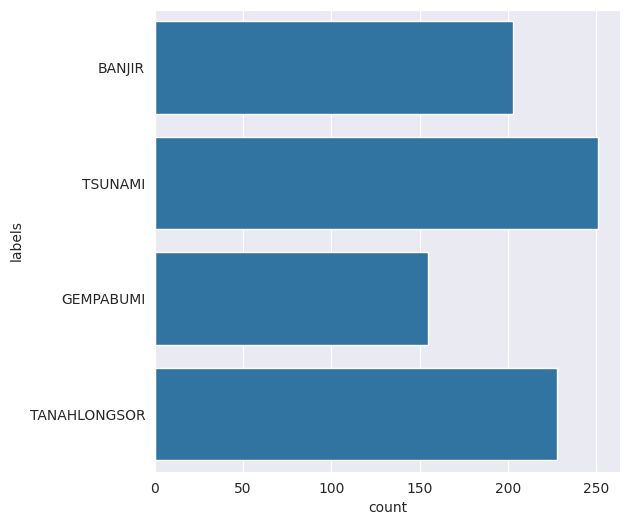

In [ ]:
ND_path = "naturaldisaster/images"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(ND_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [ ]:
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

#### BANJIR_aug

In [ ]:
images_path = "naturaldisaster/images/BANJIR"
augmented_path = "naturaldisaster/images/BANJIR"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))


images_to_generate=800
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

### gempabumi_aug

In [ ]:
images_path = "naturaldisaster/images/GEMPABUMI"
augmented_path = "naturaldisaster/images/GEMPABUMI"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=850
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

### TSUNAMI_Aug

In [ ]:
images_path = "naturaldisaster/images/TSUNAMI"
augmented_path = "naturaldisaster/images/TSUNAMI"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=750
i=1


while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

### TANAHLONGSOR

In [ ]:
images_path = "naturaldisaster/images/TANAHLONGSOR"
augmented_path = "naturaldisaster/images/TANAHLONGSOR"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=800
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

In [ ]:
print(os.listdir("naturaldisaster/images"))

['BANJIR', 'TSUNAMI', 'GEMPABUMI', 'TANAHLONGSOR']


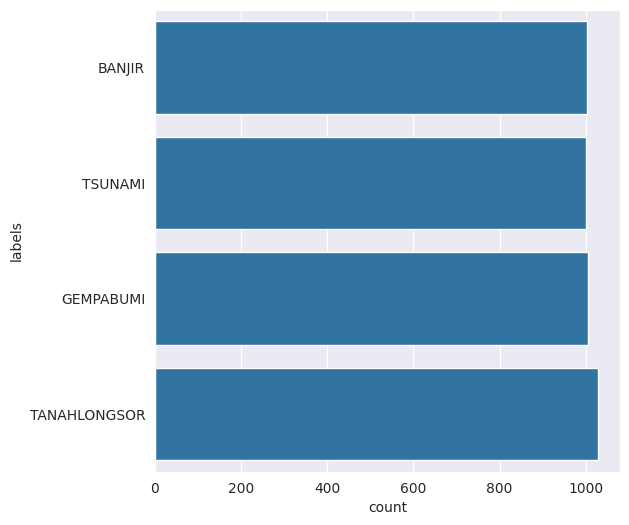

In [ ]:
ND_path = "naturaldisaster/images"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(ND_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Data splitting and testing


In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'naturaldisaster/images/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
BANJIR,1003
GEMPABUMI,1005
TANAHLONGSOR,1028
TSUNAMI,1001


In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 3229
test size 808


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels      
test   BANJIR          212
       GEMPABUMI       212
       TANAHLONGSOR    186
       TSUNAMI         198
train  BANJIR          791
       GEMPABUMI       793
       TANAHLONGSOR    842
       TSUNAMI         803
dtype: int64 


                                                   path     labels    set
636   naturaldisaster/images/BANJIR/augmented_image_...     BANJIR  train
1911  naturaldisaster/images/TSUNAMI/TSUNAMI_Image_7...    TSUNAMI  train
1500  naturaldisaster/images/GEMPABUMI/augmented_ima...  GEMPABUMI  train
182   naturaldisaster/images/BANJIR/augmented_image_...     BANJIR  train
2181  naturaldisaster/images/BANJIR/augmented_image_...     BANJIR  train


In [ ]:
datasource = "naturaldisaster/images/"
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [42]:
df_all.head()

,path,labels,set
0,naturaldisaster/images/TANAHLONGSOR/augmented_...,TANAHLONGSOR,train
1,naturaldisaster/images/TSUNAMI/augmented_image...,TSUNAMI,train
2,naturaldisaster/images/TSUNAMI/augmented_image...,TSUNAMI,train
3,naturaldisaster/images/GEMPABUMI/GEMPABUMI_Ima...,GEMPABUMI,train
4,naturaldisaster/images/BANJIR/augmented_image_...,BANJIR,train


In [44]:

# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Definisikan path untuk setiap kelas bencana alam
train_gempabumi = os.path.join(TRAIN_DIR, "GEMPABUMI")
train_banjir = os.path.join(TRAIN_DIR, "BANJIR")
train_tsunami = os.path.join(TRAIN_DIR, "TSUNAMI")
train_tanah_longsor = os.path.join(TRAIN_DIR, "TANAHLONGSOR")

test_gempabumi = os.path.join(TEST_DIR, "GEMPABUMI")
test_banjir = os.path.join(TEST_DIR, "BANJIR")
test_tsunami = os.path.join(TEST_DIR, "TSUNAMI")
test_tanah_longsor = os.path.join(TEST_DIR, "TANAHLONGSOR")

# Menampilkan jumlah gambar dalam setiap kelas
print("Total number of GEMPABUMI images in training set: ", len(os.listdir(train_gempabumi)))
print("Total number of BANJIR images in training set: ", len(os.listdir(train_banjir)))
print("Total number of TSUNAMI images in training set: ", len(os.listdir(train_tsunami)))
print("Total number of TANAHLONGSOR images in training set: ", len(os.listdir(train_tanah_longsor)))

print("Total number of GEMPABUMI images in test set: ", len(os.listdir(test_gempabumi)))
print("Total number of BANJIR images in test set: ", len(os.listdir(test_banjir)))
print("Total number of TSUNAMI images in test set: ", len(os.listdir(test_tsunami)))
print("Total number of TANAHLONGSOR images in test set: ", len(os.listdir(test_tanah_longsor)))


Total number of GEMPABUMI images in training set:  793
Total number of BANJIR images in training set:  791
Total number of TSUNAMI images in training set:  803
Total number of TANAHLONGSOR images in training set:  842
Total number of GEMPABUMI images in test set:  212
Total number of BANJIR images in test set:  212
Total number of TSUNAMI images in test set:  198
Total number of TANAHLONGSOR images in test set:  186


In [52]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='sparse',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='sparse',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='sparse',
                                                  shuffle=False)

Found 2584 images belonging to 4 classes.
Found 643 images belonging to 4 classes.
Found 806 images belonging to 4 classes.


## MODEL BUILDING

In [55]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(32, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(32, (7, 7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer Fully Connected
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [56]:
# Hitung jumlah sampel di setiap kelas
count_gempabumi = len(os.listdir(os.path.join(TRAIN_DIR, "GEMPABUMI")))
count_banjir = len(os.listdir(os.path.join(TRAIN_DIR, "BANJIR")))
count_tsunami = len(os.listdir(os.path.join(TRAIN_DIR, "TSUNAMI")))
count_tanah_longsor = len(os.listdir(os.path.join(TRAIN_DIR, "TANAHLONGSOR")))

# Total sampel
total_samples = count_gempabumi + count_banjir + count_tsunami + count_tanah_longsor

# Hitung class weights untuk masing-masing kelas
weight_gempabumi = (1 / count_gempabumi) * (total_samples / 4.0)
weight_banjir = (1 / count_banjir) * (total_samples / 4.0)
weight_tsunami = (1 / count_tsunami) * (total_samples / 4.0)
weight_tanah_longsor = (1 / count_tanah_longsor) * (total_samples / 4.0)

# Dictionary class weights
class_weights = {
    0: weight_gempabumi,
    1: weight_banjir,
    2: weight_tsunami,
    3: weight_tanah_longsor
}

print("Class Weights:", class_weights)

# Training model dengan class weights
history = model.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=test_generator,
    class_weight=class_weights
)

Class Weights: {0: 1.0179697351828498, 1: 1.0205436156763592, 2: 1.0052926525529264, 3: 0.958729216152019}
Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - accuracy: 0.3352 - loss: 2.9317 - val_accuracy: 0.2295 - val_loss: 3.2462
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.4471 - loss: 1.2493 - val_accuracy: 0.2295 - val_loss: 5.4146
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.5041 - loss: 1.1196 - val_accuracy: 0.2444 - val_loss: 2.4168
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.6038 - loss: 0.9716 - val_accuracy: 0.3672 - val_loss: 1.9234
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.6335 - loss: 0.8892 - val_accuracy: 0.3834 - val_loss: 1.6397
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.7051 - loss: 0.7346 - val_accuracy: 0.2581 - val_loss: 3.7535
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - accuracy: 0.7526 - loss: 0.6185 - val_accuracy: 0.4677 - val_los

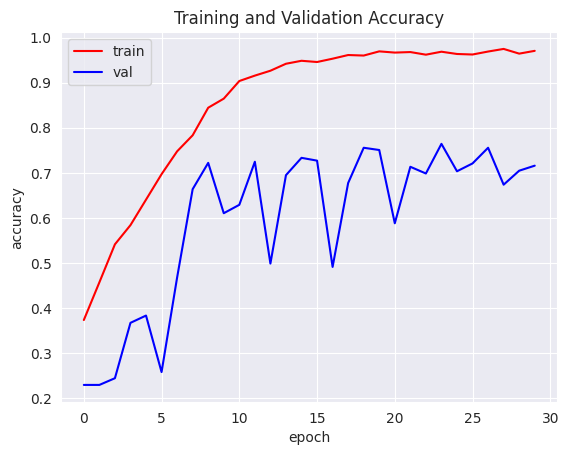

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

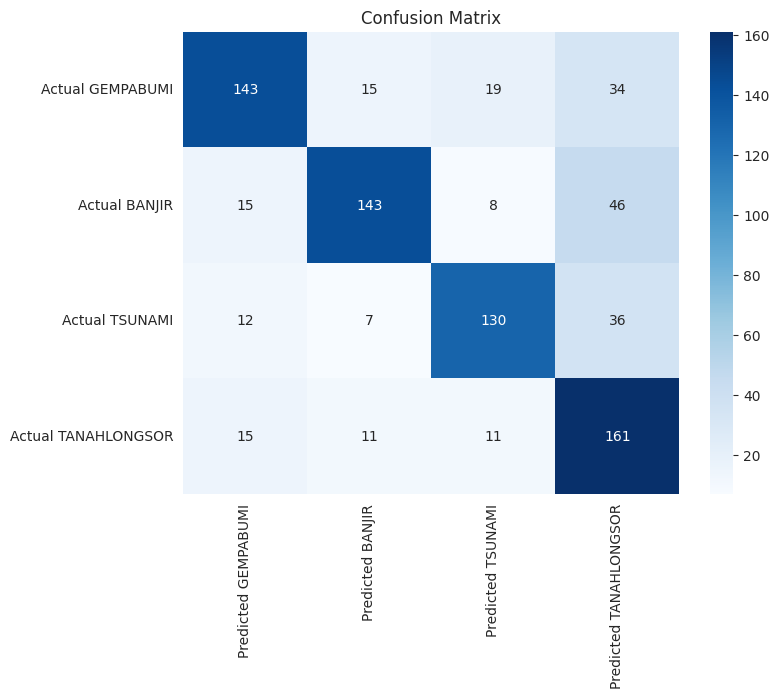


Classification Report:

              precision    recall  f1-score   support

   GEMPABUMI     0.7730    0.6777    0.7222       211
      BANJIR     0.8125    0.6745    0.7371       212
     TSUNAMI     0.7738    0.7027    0.7365       185
TANAHLONGSOR     0.5812    0.8131    0.6779       198

    accuracy                         0.7159       806
   macro avg     0.7351    0.7170    0.7184       806
weighted avg     0.7365    0.7159    0.7185       806



In [60]:
test_generator.reset()

# Prediksi
preds = model.predict(test_generator, verbose=0)
preds = np.argmax(preds, axis=1)  # Ambil indeks kelas dengan probabilitas tertinggi

# Nama kelas
class_labels = ["GEMPABUMI", "BANJIR", "TSUNAMI", "TANAHLONGSOR"]

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds),
                  index=[f"Actual {cls}" for cls in class_labels],
                  columns=[f"Predicted {cls}" for cls in class_labels])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=preds,
                            target_names=class_labels,
                            digits=4))